In [1]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import mediapipe as mp
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from keras.layers import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from tensorflow.keras import Model
import time
import cv2
import math
import time

In [5]:
import os

In [2]:
# For webcam input:
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(max_num_faces=3,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)
def get_features(pr_model, data,width=350):
    cnn_model = pr_model(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)
    features = cnn_model.predict(data, batch_size=5, verbose=1)
    return features

In [3]:
path = "eye_roi"
encoder = LabelEncoder()
encoder.classes_ = np.load(path+'/classes.npy')
model = load_model(path+"/Functional_model.h5")

# used to record the time when we processed last frame

font = cv2.FONT_HERSHEY_SIMPLEX 
# used to record the time at which we processed current frame
new_frame_time = 0


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [4]:
def process_image(image):
    prev_frame_time = 0
    image2 = image.copy()
    image2 = cv2.flip(image2, 1)

    # Flip the image horizontally for a later selfie-view display, and convert
    # the BGR image to RGB.
    image =cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    results = face_mesh.process(image)

    # Draw landmark annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    h,w,d = image.shape
    l2 =[] 
    if results.multi_face_landmarks:

        for face_landmarks in results.multi_face_landmarks:
            dict1 = {}
            a =mp_drawing.draw_landmarks(
                image=image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec)
            for idx,lm, in enumerate(face_landmarks.landmark):
                if idx in (54,123,284,352):
                    cx,cy = int(lm.x*w),int(lm.y*h)
                    if idx in  (154,284):#above Eyebrow
                        cy=cy-10
                    dict1[str(idx)] = (cx,cy)
                    cv2.circle(image,(cx,cy),5,(255,0,255),cv2.FILLED)     
                    # image = cv2.putText(image, str(idx), (cx,cy-2), cv2.FONT_HERSHEY_SIMPLEX, 
                    # 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            l2.append(dict1)

        for dict1 in l2:
            Eye_roi = image2[dict1["54"][1]:dict1["123"][1],dict1["54"][0]:dict1["352"][0]]

            Eye_roi  = cv2.resize(Eye_roi,(350,350))

            Eye_roi_reshape = Eye_roi.copy()
            Eye_roi_reshape = Eye_roi.reshape(1,350,350,3)
            print(Eye_roi_reshape.shape,"SHape********")

            inception_features = get_features(InceptionV3,Eye_roi_reshape)
            xception_features = get_features(Xception,Eye_roi_reshape)
            features_test = np.concatenate([inception_features, xception_features],axis=1)


            pred = model.predict(features_test)
            y_decode = np.argmax(pred,axis=1)
            y_decode1 = encoder.inverse_transform(y_decode)
            print(y_decode1,"Decode Emotion================")
            cv2.putText(image2, str(y_decode1[0]).upper(), (dict1["54"][0],dict1["54"][1]), font, 1, (50, 50, 250), 2, cv2.LINE_AA)
            cv2.rectangle(image2,(dict1["54"][0],dict1["54"][1]),(dict1["284"][0],dict1["123"][1]),(0,255,0),2)
        #time when we finish processing for this frame

        if camera:
            new_frame_time = time.time()
            fps = 1/(new_frame_time-prev_frame_time)
            prev_frame_time = new_frame_time
            cv2.putText(image2, "FPS:"+str(round(fps,2)), (7, 30), font, 1.2, (100, 255, 0), 2, cv2.LINE_AA)
        return image2,Eye_roi
    else:
        return image2

In [ ]:
# path="img"
camera = True
#cap = cv2.VideoCapture(0)#0 for webcam


if camera:
    while True:	
        #success, image = cap.read()qq
        #success, 
        image = cv2.imread('img1.jpg')
#         if not success:
#             print("Ignoring empty camera frame.")
#             # If loading a video, use 'break' instead of 'continue'.
#             continue
        if image.shape:
            image,roi = process_image(image)
            cv2.imshow('Eye Roi',roi)
            cv2.imshow("Image-ouput",image)
            cv2.imwrite(f"{path}/output.jpg",image)
            cv2.imwrite(f"{path}/roi.jpg",roi)
        else:
            break
#         except: 
#             print("image not load")
#             continueq
        if cv2.waitKey(1) == ord('q'):
            break
else:
    image = cv2.imread(f"img1.jpg")
    cv2.imshow('Original Image',image)
    if image.shape:
        image,roi = process_image(image)
        cv2.imwrite(f"{path}/output.jpg",image)
        cv2.imwrite(f"{path}/roi.jpg",roi)


face_mesh.close()
cap.release()
cv2.destroyAllWindows()

(1, 350, 350, 3) SHape********



1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
['fear'] Decode Emotion================
(1, 350, 350, 3) SHape********
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
['fear'] Decode Emotion================
(1, 350, 350, 3) SHape********


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
['fear'] Decode Emotion================
(1, 350, 350, 3) SHape********
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
['fear'] Decode Emotion================
(1, 350, 350, 3) SHape********
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


In [31]:
import matplotlib.pyplot as plt

## Input Image

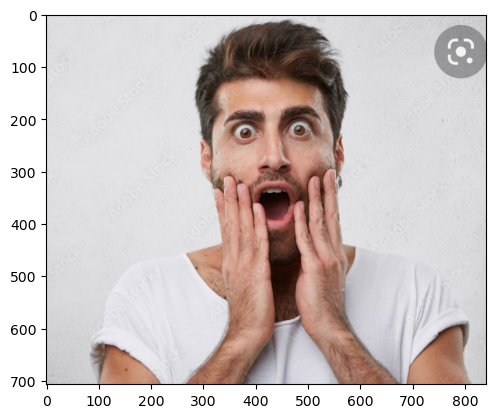

In [37]:
model_output_image = os.listdir('input')
for i in model_output_image:
    curImg = cv2.imread('input'+"/"+i)
    plt.imshow(cv2.cvtColor(curImg,cv2.COLOR_BGR2RGB))
    #plt.imshow(curImg)
    plt.show()

# Output Image

In [33]:
# data directory
path = 'Result'

In [34]:
model_output_image = os.listdir(path)

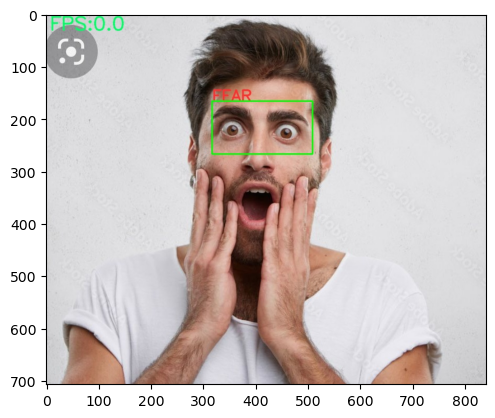

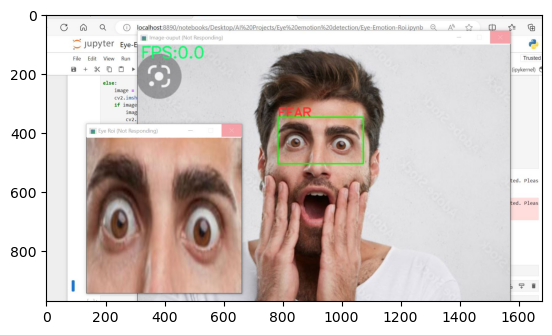

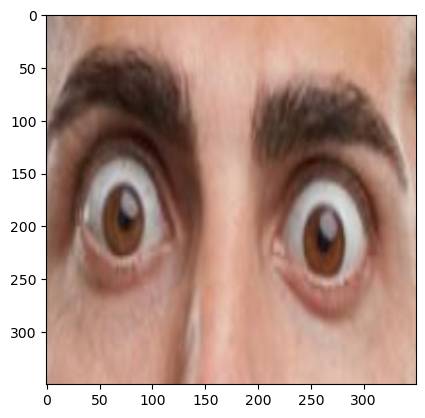

In [35]:
for img in model_output_image:
    curImg = cv2.imread(path+"/"+img)
    plt.imshow(cv2.cvtColor(curImg,cv2.COLOR_BGR2RGB))
    #plt.imshow(curImg)
    plt.show()